In [3]:
!pip install gym


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\micko\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!pip install stable-baselines3[extra]


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\micko\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import gymnasium
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

**Read Data from ALLFLOWMETER_HIKARI2021.csv file**

In [4]:
df=pd.read_csv(Path("dataset/ALLFLOWMETER_HIKARI2021.csv"))
df = df.select_dtypes(exclude=['object'])
df.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
X = df.drop(['Label'], axis=1)
y = df['Label']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Split the Dataframe into train and test**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Correlation Analysis:** Identifying Highly correlated/redundant features and removing them from the dataset

In [7]:
def drop_highly_correlated_columns(X_train, threshold=0.7):
    # Calculate the correlation matrix
    corr_matrix = X_train.corr().abs()

    # Identify columns to drop
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[i]
                to_drop.add(colname)

    # Drop the identified columns
    X_train.drop(columns=to_drop, inplace=True)

    # Print the remaining columns
    print("Remaining columns after dropping highly correlated ones:", X_train.columns)

    return to_drop

In [8]:
dropped_columns = drop_highly_correlated_columns(X_train, threshold=0.7)

Remaining columns after dropping highly correlated ones: Index(['originp', 'flow_pkts_per_sec', 'down_up_ratio', 'flow_RST_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.avg',
       'bwd_pkts_payload.min', 'flow_pkts_payload.min',
       'flow_pkts_payload.std', 'bwd_iat.min', 'bwd_iat.tot', 'flow_iat.avg',
       'payload_bytes_per_second', 'bwd_subflow_bytes', 'fwd_bulk_bytes',
       'fwd_bulk_packets', 'bwd_bulk_packets', 'fwd_bulk_rate',
       'bwd_bulk_rate', 'active.std', 'idle.tot', 'idle.avg', 'idle.std',
       'fwd_init_window_size', 'bwd_init_window_size', 'fwd_last_window_size'],
      dtype='object')


In [9]:
X_test.drop(columns=dropped_columns, inplace=True)
print(X_test)

        originp  flow_pkts_per_sec  down_up_ratio  flow_RST_flag_count  \
203148    53919         157.350815          1.000                    0   
14318       138           0.000000          0.000                    0   
52246     61126         139.757724          1.000                    0   
107333    55598           0.000000          0.000                    0   
441227    42268         103.075734          1.300                    1   
...         ...                ...            ...                  ...   
286928    33015         160.193410          1.000                    0   
214178    64784          18.609743          0.625                    0   
417668    37124         158.496920          1.000                    0   
341532    53872          78.295763          1.000                    0   
383776    60775          81.689451          1.000                    0   

        flow_ACK_flag_count  fwd_URG_flag_count  bwd_URG_flag_count  \
203148                    0             

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Random Forest Classifier:** Using Random Forest classifer model to select the 10 most important features in the dataset


In [10]:
def get_top_k_features(X, y, k=20, model_type="classifier", random_state=123):
    # Initialize the model
    if model_type == "classifier":
        rf_model = RandomForestClassifier(random_state=random_state)
    else:
        raise ValueError("model_type should be 'classifier'")

    # Fit the model
    rf_model.fit(X, y)

    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame to store feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df[:k])

    # Select top k features
    top_k_features = feature_importance_df['Feature'][:k].tolist()

    # Ensure top features are in the original dataset's columns
    top_k_features = [feature for feature in top_k_features if feature in X.columns]

    return top_k_features, feature_importance_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
top_k_features, feature_importance_df = get_top_k_features(X_train, y_train, k=20, model_type="classifier")

                     Feature  Importance
0                    originp    0.095590
16  payload_bytes_per_second    0.094157
14               bwd_iat.tot    0.092211
15              flow_iat.avg    0.088706
1          flow_pkts_per_sec    0.087247
9       fwd_pkts_payload.avg    0.073482
17         bwd_subflow_bytes    0.066258
12     flow_pkts_payload.std    0.064241
22             bwd_bulk_rate    0.055118
28      bwd_init_window_size    0.047781
13               bwd_iat.min    0.047473
2              down_up_ratio    0.042797
3        flow_RST_flag_count    0.036370
4        flow_ACK_flag_count    0.033751
29      fwd_last_window_size    0.020578
24                  idle.tot    0.012581
25                  idle.avg    0.010661
23                active.std    0.009060
20          bwd_bulk_packets    0.008244
11     flow_pkts_payload.min    0.005434


In [12]:
X_train = X_train[top_k_features]
print(X_train)

        originp  payload_bytes_per_second   bwd_iat.tot  flow_iat.avg  \
91093     55855               5151.392099  1.164908e+06  76991.942194   
362906    53045               3131.219424  0.000000e+00  28104.066849   
198842    41746                  0.000000  0.000000e+00     97.990036   
75020     14634               7175.417457  7.989020e+05  56475.453907   
220726    26060              21848.425558  9.460449e+02   8421.659470   
...         ...                       ...           ...           ...   
110268    60803                  0.000000  0.000000e+00      0.000000   
259178    19640               4789.470234  8.001401e+05  56258.161863   
365838    59878              34004.958559  2.371941e+05  12193.408879   
131932    60644               2697.263855  1.532861e+06  99519.315519   
121958    50819              16310.228408  3.972054e+03   8931.001027   

        flow_pkts_per_sec  fwd_pkts_payload.avg  bwd_subflow_bytes  \
91093           13.710106             97.750000      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
X_test = X_test[top_k_features]
print(X_test.describe())

             originp  payload_bytes_per_second   bwd_iat.tot  flow_iat.avg  \
count  111056.000000              1.110560e+05  1.110560e+05  1.110560e+05   
mean    38612.805233              3.545660e+04  7.074710e+06  1.089106e+06   
std     18075.393108              2.396936e+05  7.968790e+07  7.239695e+06   
min        21.000000              0.000000e+00  0.000000e+00  0.000000e+00   
25%     28446.750000              1.700001e+00  0.000000e+00  3.039837e+02   
50%     42624.500000              5.298073e+03  3.795624e+02  9.992085e+03   
75%     53045.000000              1.641190e+04  2.500782e+05  2.550108e+04   
max     65534.000000              4.093641e+07  1.739281e+10  6.707027e+07   

       flow_pkts_per_sec  fwd_pkts_payload.avg  bwd_subflow_bytes  \
count      111056.000000         111056.000000       1.110560e+05   
mean         3424.343644             52.503731       1.591506e+04   
std          9380.625456             52.176881       1.300927e+05   
min             0.000

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Normalizing Data:** Scaling data to a range of -1 to 1

In [14]:
def normalize_data(df, columns_standardize):
    """
    Normalize and standardize specified columns of a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be scaled.
    - columns_standardize (list): List of column names to be standardized.

    Returns:
    - pd.DataFrame: Scaled DataFrame.
    """
    # Create scalers
    standard_scaler = StandardScaler()

    # Standardize specified columns
    if columns_standardize:
        df[columns_standardize] = standard_scaler.fit_transform(df[columns_standardize])


    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
X_train = normalize_data(
    X_train.loc[:, top_k_features],
    columns_standardize=["originp", "payload_bytes_per_second","bwd_iat.tot","flow_iat.avg",
    "flow_pkts_per_sec","fwd_pkts_payload.avg","bwd_subflow_bytes","flow_pkts_payload.std",
    "bwd_bulk_rate",
    "bwd_init_window_size",
    "bwd_iat.min",
    "down_up_ratio",
    "flow_RST_flag_count",
    "flow_ACK_flag_count",
    "fwd_last_window_size",
    "idle.tot",
    "idle.avg",
    "active.std",
    "bwd_bulk_packets",
    "flow_pkts_payload.min"],

)

In [16]:
X_test = normalize_data(
    X_test.loc[:, top_k_features],
    columns_standardize=["originp", "payload_bytes_per_second","bwd_iat.tot","flow_iat.avg",
    "flow_pkts_per_sec","fwd_pkts_payload.avg","bwd_subflow_bytes","flow_pkts_payload.std",
    "bwd_bulk_rate",
    "bwd_init_window_size",
    "bwd_iat.min",
    "down_up_ratio",
    "flow_RST_flag_count",
    "flow_ACK_flag_count",
    "fwd_last_window_size",
    "idle.tot",
    "idle.avg",
    "active.std",
    "bwd_bulk_packets",
    "flow_pkts_payload.min"],
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print(X_train.describe())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


            originp  payload_bytes_per_second   bwd_iat.tot  flow_iat.avg  \
count  4.442220e+05              4.442220e+05  4.442220e+05  4.442220e+05   
mean   1.039769e-16             -1.528343e-17 -2.415278e-18 -2.699993e-17   
std    1.000001e+00              1.000001e+00  1.000001e+00  1.000001e+00   
min   -2.139755e+00             -1.649554e-01 -1.015320e-01 -1.502367e-01   
25%   -5.573212e-01             -1.649509e-01 -1.015320e-01 -1.501938e-01   
50%    2.224407e-01             -1.400513e-01 -1.015265e-01 -1.488407e-01   
75%    7.995563e-01             -8.720741e-02 -9.804080e-02 -1.467064e-01   
max    1.485632e+00              1.716566e+02  2.166403e+02  1.392824e+01   

       flow_pkts_per_sec  fwd_pkts_payload.avg  bwd_subflow_bytes  \
count       4.442220e+05          4.442220e+05       4.442220e+05   
mean        1.290814e-17         -3.192645e-17      -4.640212e-17   
std         1.000001e+00          1.000001e+00       1.000001e+00   
min        -3.642115e-01      

**Setup the Environment with OpenAI Gym**

In [65]:
class TrafficEnv(gymnasium.Env):
    def __init__(self, X, y):
        super(TrafficEnv, self).__init__()

        # Store the data
        self.X = X.values
        self.y = y.values
        self.n_samples = len(self.y)
        self.current_idx = 0

        # Define observation space (normalized features)
        n_features = self.X.shape[1]
        self.observation_space = spaces.Box(low=np.min(self.X, axis=0),
             high=np.max(self.X, axis=0),
             shape=(n_features,),
             dtype=np.float32 )

        # Define action space (binary classification: benign or malicious)
        self.action_space = spaces.Discrete(2)

        # Initialize variables for rewards and state tracking
        self.correct_classifications = 0
        self.total_classifications = 0
        self.false_positives = 0
        self.false_negatives = 0

    def reset(self, seed=None):
        """Reset the environment for a new episode."""

        self.current_idx = 0
        self.correct_classifications = 0
        self.total_classifications = 0
        self.false_positives = 0
        self.false_negatives = 0
        return self.X[self.current_idx].astype(np.float32),{}

    def step(self, action):
        """Take a step in the environment."""

        # Get the ground truth
        true_label = self.y[self.current_idx]

        # Compute reward
        if action == true_label:
          reward = 1
          self.correct_classifications += 1

        elif action==1 and true_label==0:
          reward = -0.5
          self.false_positives += 1

        else:
          reward = -1
          self.false_negatives += 1

        self.total_classifications += 1


        # Move to the next sample
        self.current_idx += 1
        done = self.current_idx >= self.n_samples

        # Return the next state, reward, done flag, and info
        if not done:
            next_state = self.X[self.current_idx].astype(np.float32)
        else:
            next_state = None

        return next_state, reward, done, False,{}

    def render(self, mode="human"):

        accuracy = self.correct_classifications / self.total_classifications
        print(f"False Positive: {self.false_positives}")
        print(f"False Negative: {self.false_negatives}")
        print(f"Correct Classifications: {self.correct_classifications}")
        print(f"Total Classifications: {self.total_classifications}")
        print(f"Accuracy: {accuracy:.2f}")

**Testing the Environment Seperately to see if it is Working**

In [ ]:
# Create the Gym environment
env = TrafficEnv(X_train, y_train)

# Testing the environment separately before integrating with DQN
state = env.reset()
done = False
total_reward = 0

while not done:
    # Random action for demonstration
    action = env.action_space.sample()

    # Step through the environment
    next_state, reward, done, truncated ,info = env.step(action)
    total_reward += reward

print(f"Total reward: {total_reward}")

Total reward: 103612.0


**Checking the Environment**

In [67]:
check_env(env)

**Using the Environment (evn) to Train the DQN**

In [68]:
# Initialize the model
model = DQN("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [69]:
model.learn(total_timesteps=10000)

In [ ]:
# Save the model
model.save("traffic_dqn_model")

model = DQN.load("traffic_dqn_model", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [89]:
state = env.reset()
done = False
total_reward_train = 0

episode_rewards_train = []  # List to store total rewards per episode
num_episodes_train = 0

while not done:
    state = state[0] if isinstance(state, tuple) else state

    # Predict action using the trained model
    action, _states = model.predict(state)
    state, reward, done, info, _ = env.step(action)
    total_reward_train += reward
    episode_rewards_train.append(total_reward_train)
    num_episodes_train += 1

print(f"Episode: {num_episodes_train} Total Reward: {total_reward_train}")
env.render()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 444222 Total Reward: 369443.0
False Positive: 10586
False Negative: 29450
Correct Classifications: 404186
Total Classifications: 444222
Accuracy: 0.91


**Graph Showing Episode vs Rewards for Training Data**

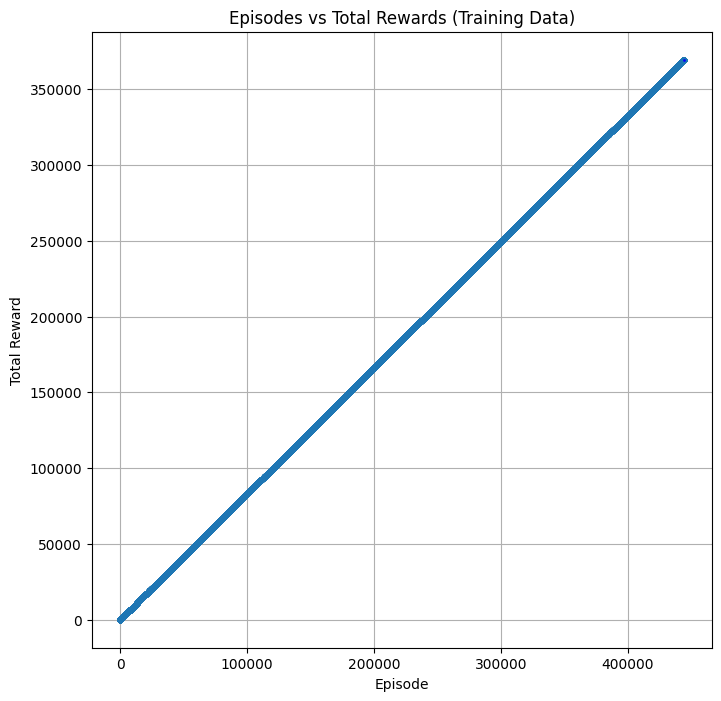

In [92]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(episode_rewards_train) + 1), episode_rewards_train, marker='o', markerfacecolor='blue', markersize=3)
plt.title("Episodes vs Total Rewards (Training Data)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

In [ ]:
plt.savefig('episode_rewards_training.png')

**Testing the model with X_test and y_test**

In [93]:
# Set the environment to use X_test and y_test
env_test = TrafficEnv(X_test, y_test)

episode_rewards_test = []  # List to store total rewards per episode
num_episodes_test = 0

state = env_test.reset()
done = False
total_reward_test = 0

while not done:
  state = state[0] if isinstance(state, tuple) else state

  action, _states = model.predict(state, deterministic=True)
  state, reward, done, info, _ = env_test.step(action)
  total_reward_test += reward
  episode_rewards_test.append(total_reward_test)
  num_episodes_test += 1

print(f"Episode: {num_episodes_test} reward: {total_reward_test}")
env_test.render()

/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Episode: 111056 reward: 96064
False Positive: 0
False Negative: 7496
Correct Classifications: 103560
Total Classifications: 111056
Accuracy: 0.93


**Graph Showing Episode vs Rewards for Testing Data**

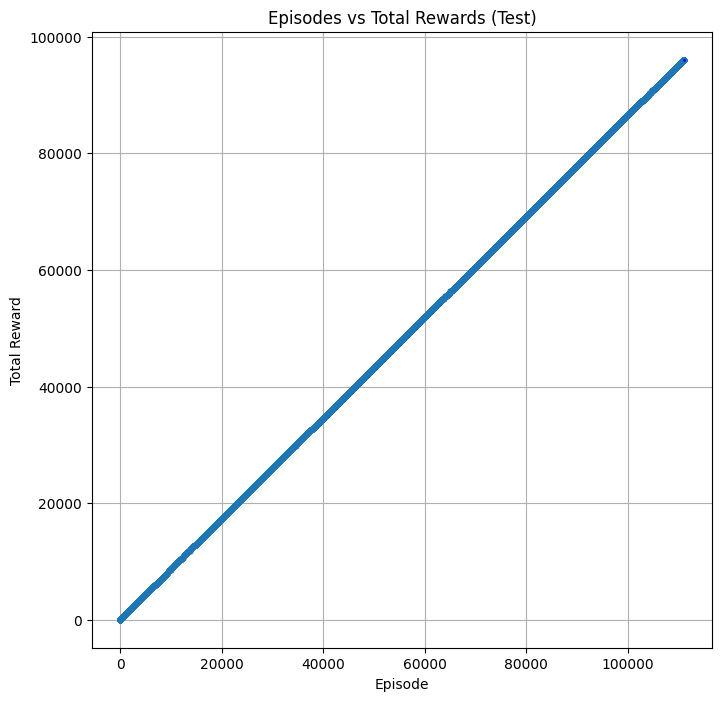

In [94]:
# Plot rewards
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(episode_rewards_test) + 1), episode_rewards_test, marker='o', markerfacecolor='blue', markersize=3)
plt.title("Episodes vs Total Rewards (Test)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

In [ ]:
plt.savefig('episode_rewards_testing.png')